# **Projeto: Quais fatores mais influenciam no desempenho de um aluno no ENEM e como podemos ajudá-lo a melhorar sua performance?**

**Integrantes:** Hellen Cristine Silva Rosa (RA00319076), João Victor Porto (RA00311353), Laura Gabriel Murayama (RA00319321), Maria Eduarda Bonel Iribarnegaray (RA00318891), Vinícius Ferreira de Mendonça (RA00319760), Vitória de Fátima Teixeira (RA00320578)

### **Importando bibliotecas e definindo funções importantes**

In [1]:
SEED = 3

# loading environment variables
from dotenv import load_dotenv
load_dotenv()

# accelerating sklearn
from sklearnex import patch_sklearn
patch_sklearn()

# importing libraries
import os
import re
import psycopg2
import pandas as pd
import numpy as np
import joblib
import skops.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

# importing sklearn functions
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

# importing python libraries
from typing import Union

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# establishing connection with DB
class db_connection():
    '''
    Instantiates a connection with the database.
    '''
    def __init__(self):
        self.DB_URI = os.environ.get('DB_URI')
         
    def __enter__(self):
        self.connection = psycopg2.connect(self.DB_URI)
        return self.connection
    
    def __exit__(self, *args):
        self.connection.close()

In [ ]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.microdados
    ORDER BY "ID" ASC;
    '''

    cursor.execute(query)
    microdados_data = cursor.fetchall()
    microdados_columns = tuple(desc[0] for desc in cursor.description)


microdados_df = pd.DataFrame(microdados_data, columns=microdados_columns).set_index('ID', drop=True)
microdados_df

In [ ]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.hab_estudo
    ORDER BY "ID" ASC;
    '''

    cursor.execute(query)
    hab_estudo_data = cursor.fetchall()
    hab_estudo_columns = tuple(desc[0] for desc in cursor.description)


hab_estudo_df = pd.DataFrame(hab_estudo_data, columns=hab_estudo_columns).set_index('ID', drop=True)
hab_estudo_df

In [ ]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.aggregated_data
    ORDER BY "NU_INSCRICAO" ASC;
    '''
    
    cursor.execute(query)
    aggregated_data = cursor.fetchall()
    aggregated_columns = tuple(desc[0] for desc in cursor.description)


aggregated_df = pd.DataFrame(aggregated_data, columns=aggregated_columns)
aggregated_df

In [3]:
aggregated_df = pd.read_csv('../aggregated_df.csv')
aggregated_df = aggregated_df.replace(np.nan, None)
aggregated_df

,NU_INSCRICAO,MICRODADOS_NU_ANO,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_SEXO,MICRODADOS_TP_ESTADO_CIVIL,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_NACIONALIDADE,MICRODADOS_TP_ST_CONCLUSAO,MICRODADOS_TP_ANO_CONCLUIU,MICRODADOS_TP_ESCOLA,...,HABESTUDO_Q033B,HABESTUDO_Q033C,HABESTUDO_Q033D,HABESTUDO_Q033E,HABESTUDO_Q033F,HABESTUDO_Q033G,HABESTUDO_Q033H,HABESTUDO_Q033I,HABESTUDO_Q033J,HABESTUDO_Q034
0,210056070067,2022,1,M,1,1,1,3,0,1,...,B,B,B,A,B,B,B,A,B,B
1,210056070068,2022,2,M,1,1,1,2,0,2,...,None,None,None,None,None,None,None,None,None,None
2,210056070069,2022,3,F,1,1,1,1,1,1,...,None,None,None,None,None,None,None,None,None,None
3,210056070070,2022,2,F,1,1,1,2,0,2,...,None,None,None,None,None,None,None,None,None,None
4,210056070071,2022,3,M,1,2,1,2,0,2,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476103,210056070062,2022,4,M,1,3,1,1,1,1,...,None,None,None,None,None,None,None,None,None,None
3476104,210056070063,2022,2,F,1,1,1,2,0,2,...,None,None,None,None,None,None,None,None,None,None
3476105,210056070064,2022,1,F,1,1,1,3,0,1,...,None,None,None,None,None,None,None,None,None,None
3476106,210056070065,2022,7,F,1,1,1,1,4,1,...,None,None,None,None,None,None,None,None,None,None


### **REQ#01: Utilizar um ou mais datasets para o treinamento dos classificadores**

Utilizaremos os microdados do ENEM 2022, [disponibilizados pelo INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem).

### **REQ#02: Análise Exploratória**

#### Verificando nulos

In [4]:
updated_aggregated_df = aggregated_df.copy()

In [5]:
updated_aggregated_df = updated_aggregated_df.dropna(
    subset=['NU_INSCRICAO', 'MICRODADOS_TP_FAIXA_ETARIA', 'MICRODADOS_TP_SEXO', 'MICRODADOS_TP_COR_RACA', 'MICRODADOS_TP_ST_CONCLUSAO', 'MICRODADOS_TP_ANO_CONCLUIU', 'MICRODADOS_TP_ESCOLA', 'MICRODADOS_TP_ENSINO', 'MICRODADOS_IN_TREINEIRO', 'MICRODADOS_SG_UF_ESC', 'MICRODADOS_TP_PRESENCA_CN', 'MICRODADOS_TP_PRESENCA_CH', 'MICRODADOS_TP_PRESENCA_LC', 'MICRODADOS_TP_PRESENCA_MT', 'MICRODADOS_NU_NOTA_CN', 'MICRODADOS_NU_NOTA_CH', 'MICRODADOS_NU_NOTA_LC', 'MICRODADOS_NU_NOTA_MT', 'MICRODADOS_NU_NOTA_REDACAO', 'MICRODADOS_TP_STATUS_REDACAO', 'MICRODADOS_NU_NOTA_COMP1', 'MICRODADOS_NU_NOTA_COMP2', 'MICRODADOS_NU_NOTA_COMP3', 'MICRODADOS_NU_NOTA_COMP4', 'MICRODADOS_NU_NOTA_COMP5', 'MICRODADOS_TP_LINGUA', 'MICRODADOS_Q005', 'MICRODADOS_Q006', 'HABESTUDO_Q001', 'HABESTUDO_Q002', 'HABESTUDO_Q003', 'HABESTUDO_Q004', 'HABESTUDO_Q005', 'HABESTUDO_Q006', 'HABESTUDO_Q007', 'HABESTUDO_Q008', 'HABESTUDO_Q009', 'HABESTUDO_Q010', 'HABESTUDO_Q011', 'HABESTUDO_Q012', 'HABESTUDO_Q013', 'HABESTUDO_Q014', 'HABESTUDO_Q015', 'HABESTUDO_Q016', 'HABESTUDO_Q017', 'HABESTUDO_Q018', 'HABESTUDO_Q019', 'HABESTUDO_Q020', 'HABESTUDO_Q021', 'HABESTUDO_Q022', 'HABESTUDO_Q023', 'HABESTUDO_Q024', 'HABESTUDO_Q025A', 'HABESTUDO_Q025B', 'HABESTUDO_Q025C', 'HABESTUDO_Q025D', 'HABESTUDO_Q025E', 'HABESTUDO_Q025F', 'HABESTUDO_Q026A', 'HABESTUDO_Q026B', 'HABESTUDO_Q026C', 'HABESTUDO_Q026D', 'HABESTUDO_Q026E', 'HABESTUDO_Q026F', 'HABESTUDO_Q026G', 'HABESTUDO_Q026H', 'HABESTUDO_Q027', 'HABESTUDO_Q028A', 'HABESTUDO_Q028B', 'HABESTUDO_Q028C', 'HABESTUDO_Q028D', 'HABESTUDO_Q028E', 'HABESTUDO_Q028F', 'HABESTUDO_Q028G', 'HABESTUDO_Q028H', 'HABESTUDO_Q028I', 'HABESTUDO_Q028J', 'HABESTUDO_Q028K', 'HABESTUDO_Q028L', 'HABESTUDO_Q028M', 'HABESTUDO_Q028N', 'HABESTUDO_Q028O', 'HABESTUDO_Q028P', 'HABESTUDO_Q028Q', 'HABESTUDO_Q028R', 'HABESTUDO_Q029', 'HABESTUDO_Q030A', 'HABESTUDO_Q030B', 'HABESTUDO_Q030C', 'HABESTUDO_Q030D', 'HABESTUDO_Q030E', 'HABESTUDO_Q030F', 'HABESTUDO_Q030G', 'HABESTUDO_Q031', 'HABESTUDO_Q032A', 'HABESTUDO_Q032B', 'HABESTUDO_Q032C', 'HABESTUDO_Q032D', 'HABESTUDO_Q032E', 'HABESTUDO_Q032F', 'HABESTUDO_Q032G', 'HABESTUDO_Q033A', 'HABESTUDO_Q033B', 'HABESTUDO_Q033C', 'HABESTUDO_Q033D', 'HABESTUDO_Q033E', 'HABESTUDO_Q033F', 'HABESTUDO_Q033G', 'HABESTUDO_Q033H', 'HABESTUDO_Q033I', 'HABESTUDO_Q033J', 'HABESTUDO_Q034']
).reset_index(drop=True)

updated_aggregated_df

,NU_INSCRICAO,MICRODADOS_NU_ANO,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_SEXO,MICRODADOS_TP_ESTADO_CIVIL,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_NACIONALIDADE,MICRODADOS_TP_ST_CONCLUSAO,MICRODADOS_TP_ANO_CONCLUIU,MICRODADOS_TP_ESCOLA,...,HABESTUDO_Q033B,HABESTUDO_Q033C,HABESTUDO_Q033D,HABESTUDO_Q033E,HABESTUDO_Q033F,HABESTUDO_Q033G,HABESTUDO_Q033H,HABESTUDO_Q033I,HABESTUDO_Q033J,HABESTUDO_Q034
0,210056070078,2022,3,M,1,1,1,2,0,2,...,B,B,B,B,B,B,A,B,B,A
1,210056070118,2022,3,M,1,2,1,2,0,2,...,B,B,B,B,B,B,B,B,B,C
2,210056070154,2022,2,F,1,1,1,2,0,2,...,B,B,B,B,B,B,B,B,A,A
3,210056070158,2022,2,F,1,1,1,2,0,2,...,A,B,B,B,B,B,B,B,B,B
4,210056070198,2022,3,M,1,1,1,2,0,2,...,A,A,B,B,B,B,B,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22279,210056069612,2022,3,M,1,3,1,2,0,2,...,B,B,B,B,A,A,B,B,B,C
22280,210056069879,2022,3,F,1,1,1,2,0,2,...,B,B,B,B,B,B,B,B,A,A
22281,210056070031,2022,2,F,1,1,1,2,0,2,...,A,B,B,B,B,B,B,B,B,B
22282,210056070043,2022,3,F,1,3,1,2,0,2,...,B,B,B,B,B,A,B,B,A,B


In [6]:
updated_aggregated_df_isna = updated_aggregated_df.isna().sum()
updated_aggregated_df_isna[updated_aggregated_df_isna != 0]

Series([], dtype: int64)

#### Criando novas variáveis

In [7]:
def get_regiao_uf(vetor_uf: pd.Series) -> pd.Series:
    '''
    Informa a região correspondente ao estado a partir de sua sigla.

    :params:
    - vetor_uf: UF do candidato (MICRODADOS_SG_UF_ESC).

    Returns a Series.
    '''

    regioes_list = []

    for uf in vetor_uf:
        regiao_uf_dict = {
            'AM': 'Norte',
            'RR': 'Norte',
            'AP': 'Norte',
            'PA': 'Norte',
            'TO': 'Norte',
            'RO': 'Norte',
            'AC': 'Norte',
            'MA': 'Nordeste',
            'PI': 'Nordeste',
            'CE': 'Nordeste',
            'RN': 'Nordeste',
            'PE': 'Nordeste',
            'PB': 'Nordeste',
            'SE': 'Nordeste',
            'AL': 'Nordeste',
            'BA': 'Nordeste',
            'MT': 'Centro-Oeste',
            'MS': 'Centro-Oeste',
            'GO': 'Centro-Oeste',
            'DF': 'Centro-Oeste',
            'SP': 'Sudeste',
            'RJ': 'Sudeste',
            'ES': 'Sudeste',
            'MG': 'Sudeste',
            'PR': 'Sul',
            'RS': 'Sul',
            'SC': 'Sul',
        }

        regiao = regiao_uf_dict[uf]
        regioes_list.append(regiao)

    return pd.Series(regioes_list)

In [8]:
def get_nota_conceito(vetor_nota_media: pd.Series, porcentagem_quartis: float) -> pd.Series:
    '''
    Converte as notas médias dos participantes em conceitos a partir da divisão dessas notas em quartis.

    :params:
    - vetor_nota_media: nota média do candidato (MICRODADOS_NU_NOTA_MEDIA).
    - porcentagem_quartis: tamanho de cada um dos quartis a ser didivido.

    Returns a Series.
    '''

    quantile_percentages = tuple(map(lambda x: round(x, 2), np.arange(0.0, (1.0 + porcentagem_quartis), porcentagem_quartis)))

    quantiles = tuple(map(lambda x: round(vetor_nota_media.quantile(x), 2), quantile_percentages))

    if quantiles[0] > vetor_nota_media.min():
        quantiles[0] = vetor_nota_media.min()
    if quantiles[-1] < vetor_nota_media.max():
        quantiles[-1] = vetor_nota_media.max()

    quantiles_intervals = tuple(zip(quantiles, quantiles[1:]))


    conceito_list = []

    for nota_media in vetor_nota_media:
        for interval_index, interval in enumerate(quantiles_intervals):
            if (interval[0] <= nota_media) and (nota_media <= interval[1]):
                conceito = interval_index
                conceito_list.append(conceito)
                break


    return pd.Series(conceito_list)

In [9]:
def count_acertos(area_prova: str, vetor_respostas: pd.Series, vetor_gabaritos: pd.Series, vetor_linguas: Union[pd.Series, None] = None) -> pd.Series:
    '''
    Conta os acertos de determinada prova.

    :params:
    - area_prova: a qual área corresponde a prova.
    - vetor_respostas: vetor de respostas do candidato.
    - vetor_gabaritos: vetor de gabaritos dada a prova do candidato.
    - vetor_linguas: caso 'area_prova' seja 'LC', a lingua deve ser indicada, sendo 0 para 'inglês' e 1 para 'espanhol'.

    Returns a Series.
    '''

    if (area_prova == 'LC') and (isinstance(vetor_linguas, type(None))):
        raise ValueError('vetor_linguas must be defined for a \'LC\' area_prova.')


    def update_gabarito_with_language(lingua: int, gabarito: str):
        if not isinstance(lingua, int):
            raise ValueError('\'lingua\' is not defined')
        elif lingua == 0:
            updated_gabarito = gabarito[:5] + gabarito[10:]
        elif lingua == 1:
            updated_gabarito = gabarito[5:]
        return updated_gabarito
    

    def check_answers_on_gabarito(acertos_list: list, respostas: str, gabarito: str, lingua: Union[int, None] = None):
        if not isinstance(respostas, str):
            acertos_list.append(None)
        else:
            if area_prova == 'LC':
                gabarito = update_gabarito_with_language(lingua, gabarito)

            acertos = 0
            for r, g in zip(respostas, gabarito):
                if r == g:
                    acertos += 1
            acertos_list.append(acertos)
    
    
    acertos_list = []
    if area_prova == 'LC':
        for respostas, gabarito, lingua in zip(vetor_respostas, vetor_gabaritos, vetor_linguas):
            check_answers_on_gabarito(acertos_list, respostas, gabarito, lingua)
    else:
        for respostas, gabarito in zip(vetor_respostas, vetor_gabaritos):
            check_answers_on_gabarito(acertos_list, respostas, gabarito)
    

    return pd.Series(acertos_list)

In [10]:
def get_mediana_renda_per_capita(vetor_renda_total: pd.Series, vetor_tamanho_grupo_familiar: pd.Series) -> pd.Series:
    '''
    Calcula a renda per capita do grupo familiar.

    :params:
    - vetor_renda_total: item de resposta da renda total (MICRODADOS_Q006).
    - vetor_tamanho_grupo_familiar: item de resposta do tamanho do grupo_familiar (MICRODADOS_Q005).

    Returns a Series.
    '''

    renda_per_capita_list = []

    for renda, tamanho_grupo_familiar in zip(vetor_renda_total, vetor_tamanho_grupo_familiar):
        renda_correspondence_dict = {
            'A': (0.00, 0.00),
            'B': (0.00, 1212.00),
            'C': (1212.01, 1818.00),
            'D': (1818.01, 2424.00),
            'E': (2424.01, 3030.00),
            'F': (3030.01, 3636.00),
            'G': (3636.01, 4848.00),
            'H': (4848.01, 6060.00),
            'I': (6060.01, 7272.00),
            'J': (7272.01, 8484.00),
            'K': (8484.01, 9696.00),
            'L': (9696.01, 10908.00),
            'M': (10908.01, 12120.00),
            'N': (12120.01, 14544.00),
            'O': (14544.01, 18180.00),
            'P': (18180.01, 24240.00),
            'Q': (24240.01, float('inf')),
        }
        intervalo_renda = renda_correspondence_dict[renda]

        if intervalo_renda:
            intervalo_renda_per_capita = tuple([amount/tamanho_grupo_familiar for amount in intervalo_renda])
            mediana_renda_per_capita = np.median(intervalo_renda_per_capita)
            mediana_renda_per_capita = round(mediana_renda_per_capita, 2)
            renda_per_capita_list.append(mediana_renda_per_capita)
        else:
            renda_per_capita_list.append(None)

    return pd.Series(renda_per_capita_list)

In [11]:
updated_aggregated_df.loc[:, 'MICRODADOS_REGIAO_ESCOLA'] = get_regiao_uf(updated_aggregated_df['MICRODADOS_SG_UF_ESC'])

updated_aggregated_df.loc[:, 'MICRODADOS_NU_NOTA_MEDIA'] = pd.Series(map(lambda x: round(x, 2), (updated_aggregated_df['MICRODADOS_NU_NOTA_CN'] + updated_aggregated_df['MICRODADOS_NU_NOTA_CH'] + updated_aggregated_df['MICRODADOS_NU_NOTA_LC'] + updated_aggregated_df['MICRODADOS_NU_NOTA_MT'] + updated_aggregated_df['MICRODADOS_NU_NOTA_REDACAO']) / 5))

updated_aggregated_df.loc[:, 'MICRODADOS_NU_NOTA_CONCEITO'] = get_nota_conceito(updated_aggregated_df['MICRODADOS_NU_NOTA_MEDIA'], 0.25)

updated_aggregated_df.loc[:, 'MICRODADOS_NU_ACERTOS_CN'] = count_acertos('CN', updated_aggregated_df['MICRODADOS_TX_RESPOSTAS_CN'], updated_aggregated_df['MICRODADOS_TX_GABARITO_CN'])
updated_aggregated_df.loc[:, 'MICRODADOS_NU_ACERTOS_CH'] = count_acertos('CH', updated_aggregated_df['MICRODADOS_TX_RESPOSTAS_CH'], updated_aggregated_df['MICRODADOS_TX_GABARITO_CH'])
updated_aggregated_df.loc[:, 'MICRODADOS_NU_ACERTOS_LC'] = count_acertos('LC', updated_aggregated_df['MICRODADOS_TX_RESPOSTAS_LC'], updated_aggregated_df['MICRODADOS_TX_GABARITO_LC'], updated_aggregated_df['MICRODADOS_TP_LINGUA'])
updated_aggregated_df.loc[:, 'MICRODADOS_NU_ACERTOS_MT'] = count_acertos('MT', updated_aggregated_df['MICRODADOS_TX_RESPOSTAS_MT'], updated_aggregated_df['MICRODADOS_TX_GABARITO_MT'])

updated_aggregated_df.loc[:, 'MICRODADOS_NU_ACERTOS_TOTAL'] = updated_aggregated_df['MICRODADOS_NU_ACERTOS_CN'] + updated_aggregated_df['MICRODADOS_NU_ACERTOS_CH'] + updated_aggregated_df['MICRODADOS_NU_ACERTOS_LC'] + updated_aggregated_df['MICRODADOS_NU_ACERTOS_MT']
updated_aggregated_df.loc[:, 'MICRODADOS_NU_ACERTOS_MEDIO'] = round(updated_aggregated_df['MICRODADOS_NU_ACERTOS_TOTAL'] / 4, 2)

updated_aggregated_df.loc[:, 'MICRODADOS_RENDA_PER_CAPITA'] = get_mediana_renda_per_capita(updated_aggregated_df['MICRODADOS_Q006'], updated_aggregated_df['MICRODADOS_Q005'])


updated_aggregated_df

,NU_INSCRICAO,MICRODADOS_NU_ANO,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_SEXO,MICRODADOS_TP_ESTADO_CIVIL,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_NACIONALIDADE,MICRODADOS_TP_ST_CONCLUSAO,MICRODADOS_TP_ANO_CONCLUIU,MICRODADOS_TP_ESCOLA,...,MICRODADOS_REGIAO_ESCOLA,MICRODADOS_NU_NOTA_MEDIA,MICRODADOS_NU_NOTA_CONCEITO,MICRODADOS_NU_ACERTOS_CN,MICRODADOS_NU_ACERTOS_CH,MICRODADOS_NU_ACERTOS_LC,MICRODADOS_NU_ACERTOS_MT,MICRODADOS_NU_ACERTOS_TOTAL,MICRODADOS_NU_ACERTOS_MEDIO,MICRODADOS_RENDA_PER_CAPITA
0,210056070078,2022,3,M,1,1,1,2,0,2,...,Sudeste,439.14,0,9,9,19,9,46,11.50,121.20
1,210056070118,2022,3,M,1,2,1,2,0,2,...,Sudeste,489.44,1,8,19,15,11,53,13.25,3838.00
2,210056070154,2022,2,F,1,1,1,2,0,2,...,Nordeste,568.10,2,9,13,22,11,55,13.75,202.00
3,210056070158,2022,2,F,1,1,1,2,0,2,...,Sudeste,554.36,2,13,18,23,13,67,16.75,681.75
4,210056070198,2022,3,M,1,1,1,2,0,2,...,Sudeste,548.96,2,16,21,26,12,75,18.75,151.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22279,210056069612,2022,3,M,1,3,1,2,0,2,...,Sudeste,555.86,2,12,16,18,18,64,16.00,1575.60
22280,210056069879,2022,3,F,1,1,1,2,0,2,...,Sudeste,478.58,1,8,10,12,10,40,10.00,909.00
22281,210056070031,2022,2,F,1,1,1,2,0,2,...,Sudeste,498.94,1,17,17,23,16,73,18.25,2878.50
22282,210056070043,2022,3,F,1,3,1,2,0,2,...,Nordeste,556.16,2,12,26,19,11,68,17.00,121.20


In [12]:
def get_hab_estudo_category_values(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Une as colunas de respostas dos hábitos de estudo por categoria, normalizando as respostas.

    :params:
    - df: DataFrame com todos os dados para substituição.

    Returns a DataFrame.
    '''

    # colocar variáveis em ordem crescente de dificuldade/falta de estudo (positividade)
    # em caso de sim/não, utilizar 'sim' como maior
    hab_estudo_correspondence_dict = {
        'HABESTUDO_ST_MAT_PERC_APR': {
            'HABESTUDO_Q001': ('E', 'D', 'C', 'B', 'A'),
            'HABESTUDO_Q002': ('C', 'B', 'A'),
            'HABESTUDO_Q003': ('E', 'D', 'C', 'B', 'A'),
            'HABESTUDO_Q004': ('F', 'E', 'D', 'C', 'B', 'A'),
            },
        'HABESTUDO_GES_TEMP_PLAN_EST': {
            'HABESTUDO_Q005': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q006': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q007': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q008': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q021': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q022': ('A', 'B', 'C', 'D'),
            },
        'HABESTUDO_PRAT_EST_PES': {
            'HABESTUDO_Q009': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q010': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q011': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q012': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q013': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q014': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q015': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q016': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q017': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q018': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q019': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q020': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q023': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q024': ('A', 'B', 'C', 'D'),
            },
        'HABESTUDO_TECN_TP_ACES': {
            'HABESTUDO_Q025A': ('B', 'A'),
            'HABESTUDO_Q025B': ('B', 'A'),
            'HABESTUDO_Q025C': ('B', 'A'),
            'HABESTUDO_Q025D': ('B', 'A'),
            'HABESTUDO_Q025E': ('B', 'A'),
            'HABESTUDO_Q025F': ('B', 'A'),
            'HABESTUDO_Q026A': ('B', 'A'),
            'HABESTUDO_Q026B': ('B', 'A'),
            'HABESTUDO_Q026C': ('B', 'A'),
            'HABESTUDO_Q026D': ('B', 'A'),
            'HABESTUDO_Q026E': ('B', 'A'),
            'HABESTUDO_Q026F': ('B', 'A'),
            'HABESTUDO_Q026G': ('B', 'A'),
            'HABESTUDO_Q026H': ('B', 'A'),
            },
        'HABESTUDO_PROB_ROT_EST': {
            'HABESTUDO_Q027': ('B', 'A'),
            'HABESTUDO_Q028A': ('B', 'A'),
            'HABESTUDO_Q028B': ('B', 'A'),
            'HABESTUDO_Q028C': ('B', 'A'),
            'HABESTUDO_Q028D': ('B', 'A'),
            'HABESTUDO_Q028E': ('B', 'A'),
            'HABESTUDO_Q028F': ('B', 'A'),
            'HABESTUDO_Q028G': ('B', 'A'),
            'HABESTUDO_Q028H': ('B', 'A'),
            'HABESTUDO_Q028I': ('B', 'A'),
            'HABESTUDO_Q028J': ('B', 'A'),
            'HABESTUDO_Q028K': ('B', 'A'),
            'HABESTUDO_Q028L': ('B', 'A'),
            'HABESTUDO_Q028M': ('B', 'A'),
            'HABESTUDO_Q028N': ('B', 'A'),
            'HABESTUDO_Q028O': ('B', 'A'),
            'HABESTUDO_Q028P': ('B', 'A'),
            'HABESTUDO_Q028Q': ('B', 'A'),
            'HABESTUDO_Q028R': ('B', 'A'),
            },
        'HABESTUDO_DIF_INFR': {
            'HABESTUDO_Q029': ('B', 'A'),
            'HABESTUDO_Q030A': ('B', 'A'),
            'HABESTUDO_Q030B': ('B', 'A'),
            'HABESTUDO_Q030C': ('B', 'A'),
            'HABESTUDO_Q030D': ('B', 'A'),
            'HABESTUDO_Q030E': ('B', 'A'),
            'HABESTUDO_Q030F': ('B', 'A'),
            'HABESTUDO_Q030G': ('B', 'A'),
            },
        'HABESTUDO_AJUD_TERC': {
            'HABESTUDO_Q031': ('C', 'A', 'B'),
            'HABESTUDO_Q032A': ('B', 'A'),
            'HABESTUDO_Q032B': ('B', 'A'),
            'HABESTUDO_Q032C': ('B', 'A'),
            'HABESTUDO_Q032D': ('B', 'A'),
            'HABESTUDO_Q032E': ('B', 'A'),
            'HABESTUDO_Q032F': ('B', 'A'),
            'HABESTUDO_Q032G': ('B', 'A'),
            'HABESTUDO_Q033A': ('B', 'A'),
            'HABESTUDO_Q033B': ('B', 'A'),
            'HABESTUDO_Q033C': ('B', 'A'),
            'HABESTUDO_Q033D': ('B', 'A'),
            'HABESTUDO_Q033E': ('B', 'A'),
            'HABESTUDO_Q033F': ('B', 'A'),
            'HABESTUDO_Q033G': ('B', 'A'),
            'HABESTUDO_Q033H': ('B', 'A'),
            'HABESTUDO_Q033I': ('B', 'A'),
            'HABESTUDO_Q033J': ('B', 'A'),
            },
        'HABESTUDO_AVAL_PROP_EXP': {
            'HABESTUDO_Q034': ('A', 'B', 'C', 'D', 'E'),
            },
    }


    for column_name, column_questions_dict in hab_estudo_correspondence_dict.items():
        column_series_dict = {}

        for question_name, question_value_list in column_questions_dict.items():
            question_series = []
            
            for student_answer in df[question_name]:
                row_value = question_value_list.index(student_answer) / (len(question_value_list) - 1)
                row_value = round(row_value, 2)
                question_series.append(row_value)
            
            column_series_dict[question_name] = question_series

        column_series = pd.Series(zip(*column_series_dict.values()))
        column_series = column_series.apply(lambda values_tuple: sum(values_tuple))

        df.loc[:, column_name] = column_series


    return df

In [13]:
updated_aggregated_df = get_hab_estudo_category_values(updated_aggregated_df)
updated_aggregated_df

,NU_INSCRICAO,MICRODADOS_NU_ANO,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_SEXO,MICRODADOS_TP_ESTADO_CIVIL,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_NACIONALIDADE,MICRODADOS_TP_ST_CONCLUSAO,MICRODADOS_TP_ANO_CONCLUIU,MICRODADOS_TP_ESCOLA,...,MICRODADOS_NU_ACERTOS_MEDIO,MICRODADOS_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,210056070078,2022,3,M,1,1,1,2,0,2,...,11.50,121.20,3.10,0.99,0.66,4.0,3.0,3.0,3.5,0.00
1,210056070118,2022,3,M,1,2,1,2,0,2,...,13.25,3838.00,3.55,1.65,5.64,4.0,3.0,2.0,2.5,0.50
2,210056070154,2022,2,F,1,1,1,2,0,2,...,13.75,202.00,3.10,1.65,3.98,2.0,3.0,2.0,2.5,0.00
3,210056070158,2022,2,F,1,1,1,2,0,2,...,16.75,681.75,3.35,4.35,10.01,4.0,8.0,3.0,4.5,0.25
4,210056070198,2022,3,M,1,1,1,2,0,2,...,18.75,151.50,3.10,3.66,14.00,4.0,7.0,3.0,3.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22279,210056069612,2022,3,M,1,3,1,2,0,2,...,16.00,1575.60,3.10,2.66,5.64,3.0,2.0,3.0,3.5,0.50
22280,210056069879,2022,3,F,1,1,1,2,0,2,...,10.00,909.00,3.10,1.32,3.96,4.0,6.0,3.0,2.5,0.00
22281,210056070031,2022,2,F,1,1,1,2,0,2,...,18.25,2878.50,3.10,4.68,8.70,4.0,3.0,2.0,2.5,0.25
22282,210056070043,2022,3,F,1,3,1,2,0,2,...,17.00,121.20,3.35,1.98,4.62,2.0,2.0,3.0,4.5,0.25


In [14]:
updated_aggregated_df[(updated_aggregated_df['NU_INSCRICAO'] == 210054496687) | (updated_aggregated_df['NU_INSCRICAO'] == 210054497031)][['MICRODADOS_NU_NOTA_MEDIA', 'MICRODADOS_NU_NOTA_CONCEITO']]

,MICRODADOS_NU_NOTA_MEDIA,MICRODADOS_NU_NOTA_CONCEITO
12907,453.56,0
12908,553.50,2


#### Filtrando variáveis

In [15]:
interest_variables = ['NU_INSCRICAO', 'MICRODADOS_TP_FAIXA_ETARIA', 'MICRODADOS_TP_SEXO', 'MICRODADOS_TP_COR_RACA', 'MICRODADOS_TP_ST_CONCLUSAO', 'MICRODADOS_TP_ANO_CONCLUIU', 'MICRODADOS_TP_ESCOLA', 'MICRODADOS_TP_ENSINO', 'MICRODADOS_IN_TREINEIRO', 'MICRODADOS_REGIAO_ESCOLA', 'MICRODADOS_TP_PRESENCA_CN', 'MICRODADOS_TP_PRESENCA_CH', 'MICRODADOS_TP_PRESENCA_LC', 'MICRODADOS_TP_PRESENCA_MT', 'MICRODADOS_NU_NOTA_CN', 'MICRODADOS_NU_NOTA_CH', 'MICRODADOS_NU_NOTA_LC', 'MICRODADOS_NU_NOTA_MT', 'MICRODADOS_NU_NOTA_REDACAO', 'MICRODADOS_TP_STATUS_REDACAO', 'MICRODADOS_NU_NOTA_COMP1', 'MICRODADOS_NU_NOTA_COMP2', 'MICRODADOS_NU_NOTA_COMP3', 'MICRODADOS_NU_NOTA_COMP4', 'MICRODADOS_NU_NOTA_COMP5', 'MICRODADOS_NU_NOTA_MEDIA', 'MICRODADOS_NU_NOTA_CONCEITO', 'MICRODADOS_NU_ACERTOS_CN', 'MICRODADOS_NU_ACERTOS_CH', 'MICRODADOS_NU_ACERTOS_LC', 'MICRODADOS_NU_ACERTOS_MT', 'MICRODADOS_NU_ACERTOS_TOTAL', 'MICRODADOS_NU_ACERTOS_MEDIO', 'MICRODADOS_TP_LINGUA', 'MICRODADOS_RENDA_PER_CAPITA', 'HABESTUDO_ST_MAT_PERC_APR', 'HABESTUDO_GES_TEMP_PLAN_EST', 'HABESTUDO_PRAT_EST_PES', 'HABESTUDO_TECN_TP_ACES', 'HABESTUDO_PROB_ROT_EST', 'HABESTUDO_DIF_INFR', 'HABESTUDO_AJUD_TERC', 'HABESTUDO_AVAL_PROP_EXP']

filtered_aggregated_df = updated_aggregated_df.loc[:, interest_variables]
filtered_aggregated_df

,NU_INSCRICAO,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_SEXO,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_ST_CONCLUSAO,MICRODADOS_TP_ANO_CONCLUIU,MICRODADOS_TP_ESCOLA,MICRODADOS_TP_ENSINO,MICRODADOS_IN_TREINEIRO,MICRODADOS_REGIAO_ESCOLA,...,MICRODADOS_TP_LINGUA,MICRODADOS_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,210056070078,3,M,1,2,0,2,1.0,0,Sudeste,...,1,121.20,3.10,0.99,0.66,4.0,3.0,3.0,3.5,0.00
1,210056070118,3,M,2,2,0,2,1.0,0,Sudeste,...,0,3838.00,3.55,1.65,5.64,4.0,3.0,2.0,2.5,0.50
2,210056070154,2,F,1,2,0,2,1.0,0,Nordeste,...,1,202.00,3.10,1.65,3.98,2.0,3.0,2.0,2.5,0.00
3,210056070158,2,F,1,2,0,2,1.0,0,Sudeste,...,0,681.75,3.35,4.35,10.01,4.0,8.0,3.0,4.5,0.25
4,210056070198,3,M,1,2,0,2,1.0,0,Sudeste,...,0,151.50,3.10,3.66,14.00,4.0,7.0,3.0,3.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22279,210056069612,3,M,3,2,0,2,1.0,0,Sudeste,...,0,1575.60,3.10,2.66,5.64,3.0,2.0,3.0,3.5,0.50
22280,210056069879,3,F,1,2,0,2,1.0,0,Sudeste,...,1,909.00,3.10,1.32,3.96,4.0,6.0,3.0,2.5,0.00
22281,210056070031,2,F,1,2,0,2,1.0,0,Sudeste,...,0,2878.50,3.10,4.68,8.70,4.0,3.0,2.0,2.5,0.25
22282,210056070043,3,F,3,2,0,2,1.0,0,Nordeste,...,0,121.20,3.35,1.98,4.62,2.0,2.0,3.0,4.5,0.25


#### Exportando dados localmente e para o DB

In [16]:
filtered_aggregated_df.to_csv('../filtered_aggregated_df.csv', index=False)

In [17]:
filtered_aggregated_data_creation_query = '''
CREATE TABLE projeto_enem.filtered_aggregated_data (
	"NU_INSCRICAO" BIGINT PRIMARY KEY,
	"MICRODADOS_TP_FAIXA_ETARIA" INTEGER,
	"MICRODADOS_TP_SEXO" VARCHAR(1),
	"MICRODADOS_TP_COR_RACA" INTEGER,
	"MICRODADOS_TP_ST_CONCLUSAO" INTEGER,
	"MICRODADOS_TP_ANO_CONCLUIU" INTEGER,
	"MICRODADOS_TP_ESCOLA" INTEGER,
	"MICRODADOS_TP_ENSINO" FLOAT,
	"MICRODADOS_IN_TREINEIRO" INTEGER,
	"MICRODADOS_REGIAO_ESCOLA" VARCHAR(12),
	"MICRODADOS_TP_PRESENCA_CN" INTEGER,
	"MICRODADOS_TP_PRESENCA_CH" INTEGER,
	"MICRODADOS_TP_PRESENCA_LC" INTEGER,
	"MICRODADOS_TP_PRESENCA_MT" INTEGER,
	"MICRODADOS_NU_NOTA_CN" FLOAT,
	"MICRODADOS_NU_NOTA_CH" FLOAT,
	"MICRODADOS_NU_NOTA_LC" FLOAT,
	"MICRODADOS_NU_NOTA_MT" FLOAT,
	"MICRODADOS_NU_NOTA_REDACAO" FLOAT,
	"MICRODADOS_TP_STATUS_REDACAO" FLOAT,
	"MICRODADOS_NU_NOTA_COMP1" FLOAT,
	"MICRODADOS_NU_NOTA_COMP2" FLOAT,
	"MICRODADOS_NU_NOTA_COMP3" FLOAT,
	"MICRODADOS_NU_NOTA_COMP4" FLOAT,
	"MICRODADOS_NU_NOTA_COMP5" FLOAT,
	"MICRODADOS_NU_NOTA_MEDIA" FLOAT,
    "MICRODADOS_NU_NOTA_CONCEITO" INTEGER, 
	"MICRODADOS_NU_ACERTOS_CN" INTEGER,
	"MICRODADOS_NU_ACERTOS_CH" INTEGER,
	"MICRODADOS_NU_ACERTOS_LC" INTEGER,
	"MICRODADOS_NU_ACERTOS_MT" INTEGER,
	"MICRODADOS_NU_ACERTOS_TOTAL" INTEGER,
	"MICRODADOS_NU_ACERTOS_MEDIO" FLOAT,
	"MICRODADOS_TP_LINGUA" INTEGER,
	"MICRODADOS_RENDA_PER_CAPITA" FLOAT,
	"HABESTUDO_ST_MAT_PERC_APR" FLOAT,
	"HABESTUDO_GES_TEMP_PLAN_EST" FLOAT,
	"HABESTUDO_PRAT_EST_PES" FLOAT,
	"HABESTUDO_TECN_TP_ACES" FLOAT,
	"HABESTUDO_PROB_ROT_EST" FLOAT,
	"HABESTUDO_DIF_INFR" FLOAT,
	"HABESTUDO_AJUD_TERC" FLOAT,
	"HABESTUDO_AVAL_PROP_EXP" FLOAT
);
'''

filtered_aggregated_csv_query = '''
COPY projeto_enem.filtered_aggregated_data("NU_INSCRICAO", "MICRODADOS_TP_FAIXA_ETARIA", "MICRODADOS_TP_SEXO", "MICRODADOS_TP_COR_RACA", "MICRODADOS_TP_ST_CONCLUSAO", "MICRODADOS_TP_ANO_CONCLUIU", "MICRODADOS_TP_ESCOLA", "MICRODADOS_TP_ENSINO", "MICRODADOS_IN_TREINEIRO", "MICRODADOS_REGIAO_ESCOLA", "MICRODADOS_TP_PRESENCA_CN", "MICRODADOS_TP_PRESENCA_CH", "MICRODADOS_TP_PRESENCA_LC", "MICRODADOS_TP_PRESENCA_MT", "MICRODADOS_NU_NOTA_CN", "MICRODADOS_NU_NOTA_CH", "MICRODADOS_NU_NOTA_LC", "MICRODADOS_NU_NOTA_MT", "MICRODADOS_NU_NOTA_REDACAO", "MICRODADOS_TP_STATUS_REDACAO", "MICRODADOS_NU_NOTA_COMP1", "MICRODADOS_NU_NOTA_COMP2", "MICRODADOS_NU_NOTA_COMP3", "MICRODADOS_NU_NOTA_COMP4", "MICRODADOS_NU_NOTA_COMP5", "MICRODADOS_NU_NOTA_MEDIA", "MICRODADOS_NU_NOTA_CONCEITO", "MICRODADOS_NU_ACERTOS_CN", "MICRODADOS_NU_ACERTOS_CH", "MICRODADOS_NU_ACERTOS_LC", "MICRODADOS_NU_ACERTOS_MT", "MICRODADOS_NU_ACERTOS_TOTAL", "MICRODADOS_NU_ACERTOS_MEDIO", "MICRODADOS_TP_LINGUA", "MICRODADOS_RENDA_PER_CAPITA", "HABESTUDO_ST_MAT_PERC_APR", "HABESTUDO_GES_TEMP_PLAN_EST", "HABESTUDO_PRAT_EST_PES", "HABESTUDO_TECN_TP_ACES", "HABESTUDO_PROB_ROT_EST", "HABESTUDO_DIF_INFR", "HABESTUDO_AJUD_TERC", "HABESTUDO_AVAL_PROP_EXP")
FROM STDIN
WITH (DELIMITER ',',
ENCODING 'utf8',
FORMAT CSV,
HEADER);
'''


with db_connection() as conn, conn.cursor() as cursor:
    cursor.execute(filtered_aggregated_data_creation_query)
    conn.commit()
    
    with open('../filtered_aggregated_df.csv', encoding='utf8') as filtered_aggregated_csv_file:
        cursor.copy_expert(filtered_aggregated_csv_query, filtered_aggregated_csv_file)
        conn.commit()

#### Selecionando variáveis

In [18]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.filtered_aggregated_data
    ORDER BY "NU_INSCRICAO" ASC;
    '''
    
    cursor.execute(query)
    filtered_aggregated_data = cursor.fetchall()
    filtered_aggregated_columns = tuple(desc[0] for desc in cursor.description)


filtered_aggregated_df = pd.DataFrame(filtered_aggregated_data, columns=filtered_aggregated_columns)
filtered_aggregated_df

,NU_INSCRICAO,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_SEXO,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_ST_CONCLUSAO,MICRODADOS_TP_ANO_CONCLUIU,MICRODADOS_TP_ESCOLA,MICRODADOS_TP_ENSINO,MICRODADOS_IN_TREINEIRO,MICRODADOS_REGIAO_ESCOLA,...,MICRODADOS_TP_LINGUA,MICRODADOS_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,210056070078,3,M,1,2,0,2,1.0,0,Sudeste,...,1,121.20,3.10,0.99,0.66,4.0,3.0,3.0,3.5,0.00
1,210056070118,3,M,2,2,0,2,1.0,0,Sudeste,...,0,3838.00,3.55,1.65,5.64,4.0,3.0,2.0,2.5,0.50
2,210056070154,2,F,1,2,0,2,1.0,0,Nordeste,...,1,202.00,3.10,1.65,3.98,2.0,3.0,2.0,2.5,0.00
3,210056070158,2,F,1,2,0,2,1.0,0,Sudeste,...,0,681.75,3.35,4.35,10.01,4.0,8.0,3.0,4.5,0.25
4,210056070198,3,M,1,2,0,2,1.0,0,Sudeste,...,0,151.50,3.10,3.66,14.00,4.0,7.0,3.0,3.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22279,210056069612,3,M,3,2,0,2,1.0,0,Sudeste,...,0,1575.60,3.10,2.66,5.64,3.0,2.0,3.0,3.5,0.50
22280,210056069879,3,F,1,2,0,2,1.0,0,Sudeste,...,1,909.00,3.10,1.32,3.96,4.0,6.0,3.0,2.5,0.00
22281,210056070031,2,F,1,2,0,2,1.0,0,Sudeste,...,0,2878.50,3.10,4.68,8.70,4.0,3.0,2.0,2.5,0.25
22282,210056070043,3,F,3,2,0,2,1.0,0,Nordeste,...,0,121.20,3.35,1.98,4.62,2.0,2.0,3.0,4.5,0.25


**Pré-processamento**

**nominal:** 'MICRODADOS_TP_SEXO', 'MICRODADOS_REGIAO_ESCOLA'

**numerical:** 'NU_INSCRICAO', 'MICRODADOS_TP_FAIXA_ETARIA', 'MICRODADOS_TP_COR_RACA', 'MICRODADOS_TP_ST_CONCLUSAO', 'MICRODADOS_TP_ANO_CONCLUIU', 'MICRODADOS_TP_ESCOLA', 'MICRODADOS_TP_ENSINO', 'MICRODADOS_IN_TREINEIRO', 'MICRODADOS_TP_PRESENCA_CN', 'MICRODADOS_TP_PRESENCA_CH', 'MICRODADOS_TP_PRESENCA_LC', 'MICRODADOS_TP_PRESENCA_MT', 'MICRODADOS_NU_NOTA_CN', 'MICRODADOS_NU_NOTA_CH', 'MICRODADOS_NU_NOTA_LC', 'MICRODADOS_NU_NOTA_MT', 'MICRODADOS_NU_NOTA_REDACAO', 'MICRODADOS_TP_STATUS_REDACAO', 'MICRODADOS_NU_NOTA_COMP1', 'MICRODADOS_NU_NOTA_COMP2', 'MICRODADOS_NU_NOTA_COMP3', 'MICRODADOS_NU_NOTA_COMP4', 'MICRODADOS_NU_NOTA_COMP5', 'MICRODADOS_NU_NOTA_MEDIA', 'MICRODADOS_NU_NOTA_CONCEITO', 'MICRODADOS_NU_ACERTOS_CN', 'MICRODADOS_NU_ACERTOS_CH', 'MICRODADOS_NU_ACERTOS_LC', 'MICRODADOS_NU_ACERTOS_MT', 'MICRODADOS_NU_ACERTOS_TOTAL', 'MICRODADOS_NU_ACERTOS_MEDIO', 'MICRODADOS_TP_LINGUA', 'MICRODADOS_RENDA_PER_CAPITA', 'HABESTUDO_ST_MAT_PERC_APR', 'HABESTUDO_GES_TEMP_PLAN_EST', 'HABESTUDO_PRAT_EST_PES', 'HABESTUDO_TECN_TP_ACES', 'HABESTUDO_PROB_ROT_EST', 'HABESTUDO_DIF_INFR', 'HABESTUDO_AJUD_TERC', 'HABESTUDO_AVAL_PROP_EXP'

In [21]:
nominal_features = list(set(filtered_aggregated_df.select_dtypes(include='object').columns.values))
numerical_features = list(set(filtered_aggregated_df.select_dtypes(exclude='object').columns.values))

In [22]:
nominal_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder()),
])

preprocessor = ColumnTransformer(transformers=[
    ('nominal', nominal_transformer, nominal_features),
], remainder='passthrough')

scaler_processing = Pipeline(steps=[
    ('minmaxscaler', MinMaxScaler()),
    ('stdscaler',  StandardScaler()),
])

In [23]:
X = filtered_aggregated_df.drop(columns=['NU_INSCRICAO', 'MICRODADOS_NU_NOTA_MEDIA', 'MICRODADOS_NU_NOTA_CONCEITO'])
y_numerical = filtered_aggregated_df['MICRODADOS_NU_NOTA_MEDIA']
y_categorical = filtered_aggregated_df['MICRODADOS_NU_NOTA_CONCEITO']

X_transformed = preprocessor.fit_transform(X)
y_numerical_transformed = y_numerical
y_categorical_transformed = y_categorical

In [24]:
preprocessor_feature_names = preprocessor.get_feature_names_out()
preprocessor_feature_names = [re.sub(r'.+__', '', item) for item in preprocessor_feature_names]

In [25]:
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor_feature_names)
X_transformed

,MICRODADOS_REGIAO_ESCOLA_Centro-Oeste,MICRODADOS_REGIAO_ESCOLA_Nordeste,MICRODADOS_REGIAO_ESCOLA_Norte,MICRODADOS_REGIAO_ESCOLA_Sudeste,MICRODADOS_REGIAO_ESCOLA_Sul,MICRODADOS_TP_SEXO_F,MICRODADOS_TP_SEXO_M,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_ST_CONCLUSAO,...,MICRODADOS_TP_LINGUA,MICRODADOS_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,2.0,...,1.0,121.20,3.10,0.99,0.66,4.0,3.0,3.0,3.5,0.00
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,2.0,2.0,...,0.0,3838.00,3.55,1.65,5.64,4.0,3.0,2.0,2.5,0.50
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,...,1.0,202.00,3.10,1.65,3.98,2.0,3.0,2.0,2.5,0.00
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,681.75,3.35,4.35,10.01,4.0,8.0,3.0,4.5,0.25
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,2.0,...,0.0,151.50,3.10,3.66,14.00,4.0,7.0,3.0,3.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22279,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,3.0,2.0,...,0.0,1575.60,3.10,2.66,5.64,3.0,2.0,3.0,3.5,0.50
22280,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,2.0,...,1.0,909.00,3.10,1.32,3.96,4.0,6.0,3.0,2.5,0.00
22281,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,2878.50,3.10,4.68,8.70,4.0,3.0,2.0,2.5,0.25
22282,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,2.0,...,0.0,121.20,3.35,1.98,4.62,2.0,2.0,3.0,4.5,0.25


**Avaliando correlação**

In [26]:
def plot_corr(ax, train_data, title):
    corr = train_data.corr(method='spearman')
    cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=ax)
    graph.set_title(title, pad=10)

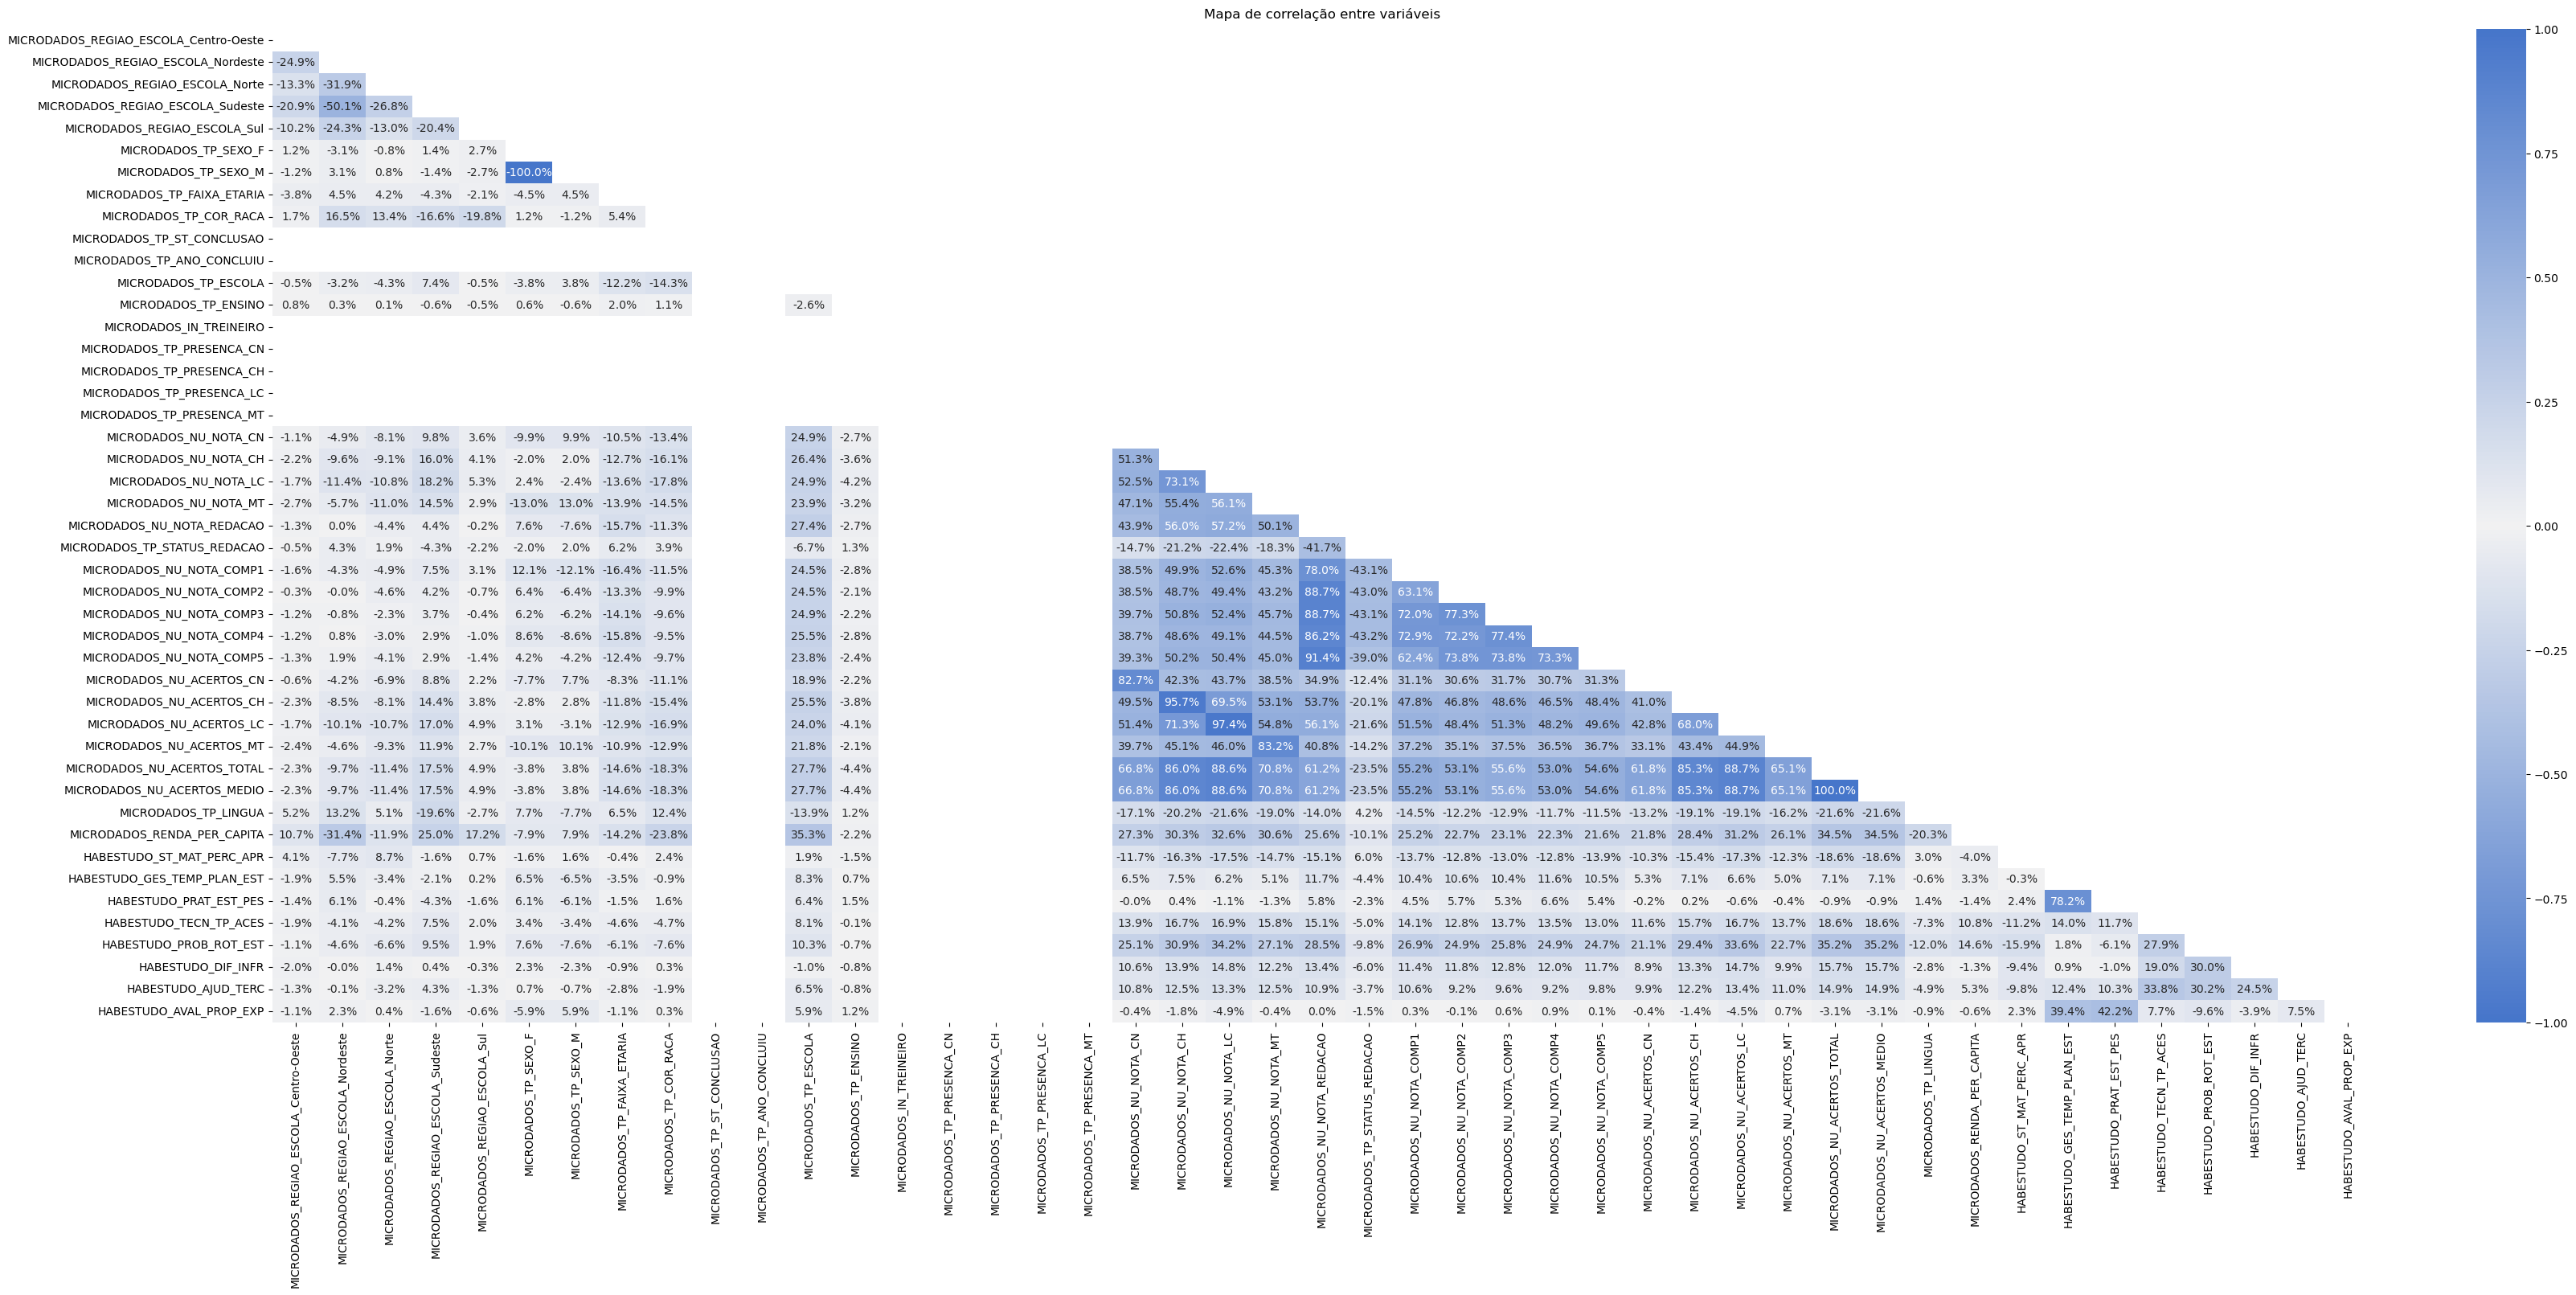

In [27]:
fig, ax = plt.subplots(figsize=(32, 16), constrained_layout=True)

plot_corr(ax, X_transformed, 'Mapa de correlação entre variáveis')
plt.show()

In [28]:
columns_to_drop = ['MICRODADOS_TP_ST_CONCLUSAO', 'MICRODADOS_TP_ANO_CONCLUIU', 'MICRODADOS_IN_TREINEIRO', 'MICRODADOS_TP_PRESENCA_CN', 'MICRODADOS_TP_PRESENCA_CH', 'MICRODADOS_TP_PRESENCA_LC', 'MICRODADOS_TP_PRESENCA_MT', 'MICRODADOS_TP_SEXO_M', 'MICRODADOS_NU_ACERTOS_MEDIO', 'MICRODADOS_NU_ACERTOS_CN', 'MICRODADOS_NU_ACERTOS_CH', 'MICRODADOS_NU_ACERTOS_LC', 'MICRODADOS_NU_ACERTOS_MT', 'MICRODADOS_NU_NOTA_CN', 'MICRODADOS_NU_NOTA_CH', 'MICRODADOS_NU_NOTA_LC', 'MICRODADOS_NU_NOTA_MT', 'MICRODADOS_NU_NOTA_REDACAO', 'MICRODADOS_TP_STATUS_REDACAO', 'MICRODADOS_NU_NOTA_COMP1', 'MICRODADOS_NU_NOTA_COMP2', 'MICRODADOS_NU_NOTA_COMP3', 'MICRODADOS_NU_NOTA_COMP4', 'MICRODADOS_NU_NOTA_COMP5', 'MICRODADOS_NU_ACERTOS_TOTAL', 'MICRODADOS_TP_LINGUA']

X_transformed_dropped = X_transformed.drop(columns=columns_to_drop)
X_transformed_dropped

,MICRODADOS_REGIAO_ESCOLA_Centro-Oeste,MICRODADOS_REGIAO_ESCOLA_Nordeste,MICRODADOS_REGIAO_ESCOLA_Norte,MICRODADOS_REGIAO_ESCOLA_Sudeste,MICRODADOS_REGIAO_ESCOLA_Sul,MICRODADOS_TP_SEXO_F,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_ESCOLA,MICRODADOS_TP_ENSINO,MICRODADOS_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,2.0,1.0,121.20,3.10,0.99,0.66,4.0,3.0,3.0,3.5,0.00
1,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0,3838.00,3.55,1.65,5.64,4.0,3.0,2.0,2.5,0.50
2,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,202.00,3.10,1.65,3.98,2.0,3.0,2.0,2.5,0.00
3,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0,681.75,3.35,4.35,10.01,4.0,8.0,3.0,4.5,0.25
4,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,2.0,1.0,151.50,3.10,3.66,14.00,4.0,7.0,3.0,3.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22279,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,2.0,1.0,1575.60,3.10,2.66,5.64,3.0,2.0,3.0,3.5,0.50
22280,0.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,2.0,1.0,909.00,3.10,1.32,3.96,4.0,6.0,3.0,2.5,0.00
22281,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0,2878.50,3.10,4.68,8.70,4.0,3.0,2.0,2.5,0.25
22282,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,1.0,121.20,3.35,1.98,4.62,2.0,2.0,3.0,4.5,0.25


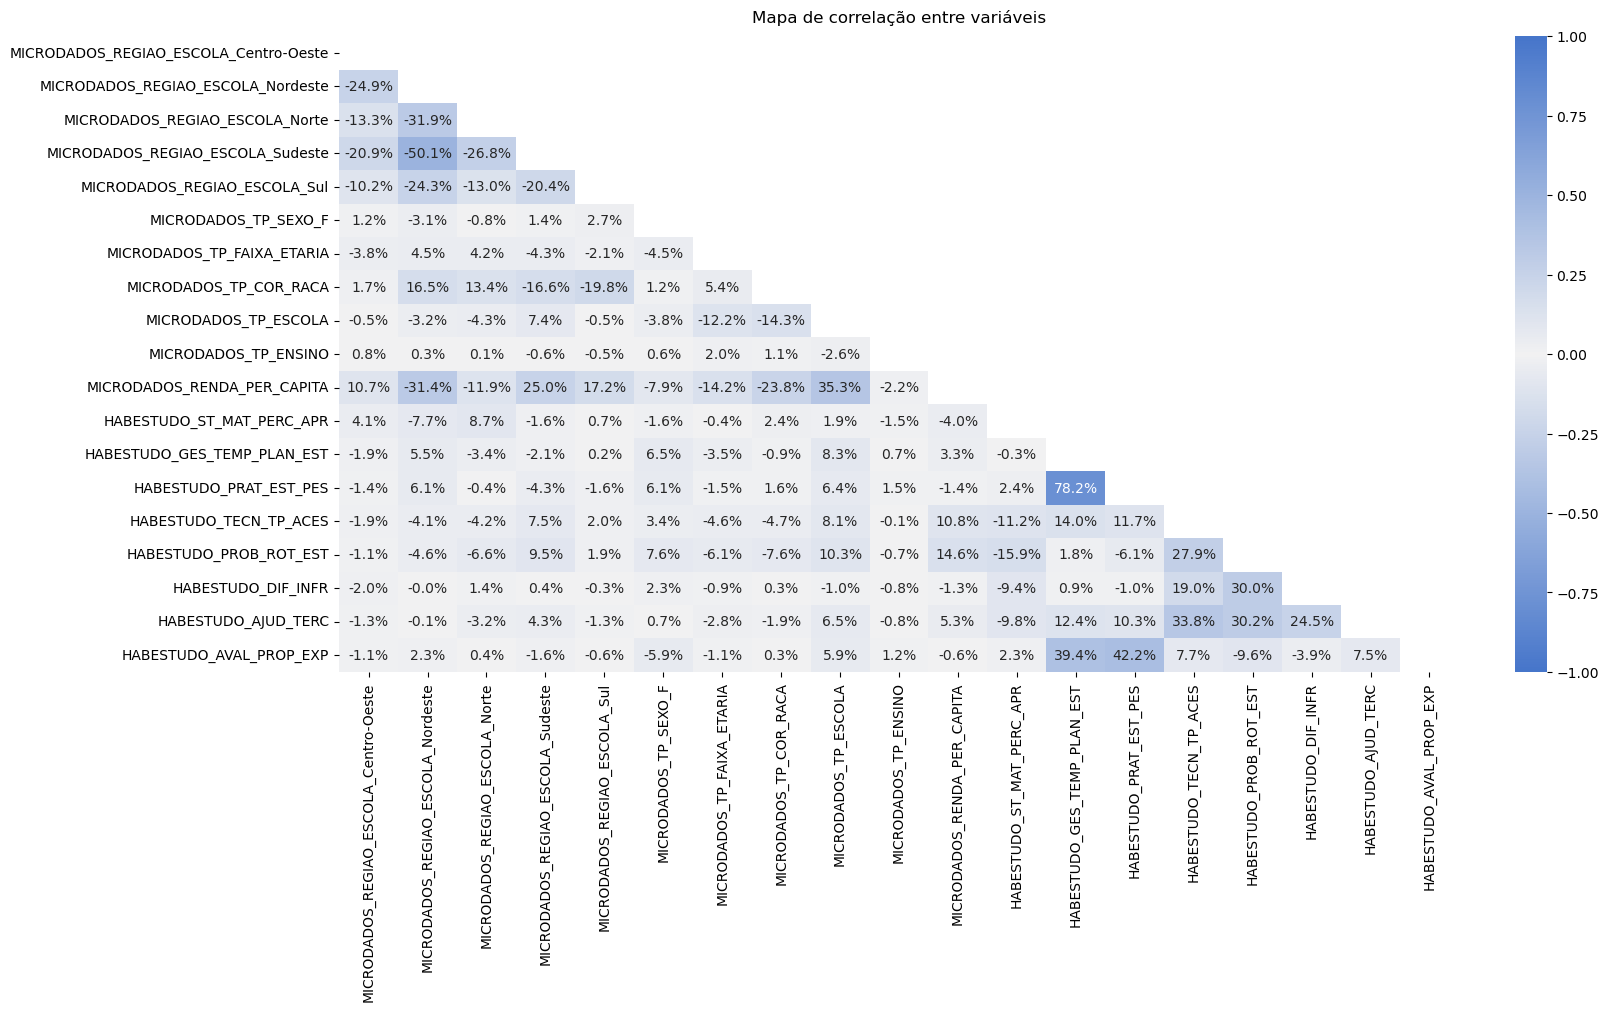

In [29]:
fig, ax = plt.subplots(figsize=(16, 10), constrained_layout=True)

plot_corr(ax, X_transformed_dropped, 'Mapa de correlação entre variáveis')
plt.show()

*Conclusões:*
- Linguagens e Humanas são as áreas que mais influenciam no número de acertos total;
- A competência 5 é a que mais influencia na nota de Redação;
- As categorias Gestão de Tempo e Planejamento de Estudos e Práticas de Estudo e Pesquisa são as mais relacionadas.

**Avaliando importância das variáveis**

In [30]:
renda_inf_indexes = X_transformed_dropped[X_transformed_dropped['MICRODADOS_RENDA_PER_CAPITA'] == float('inf')].index
X_transformed_dropped = X_transformed_dropped.drop(index=renda_inf_indexes).reset_index(drop=True)
y_numerical_transformed = y_numerical_transformed.drop(index=renda_inf_indexes).reset_index(drop=True)
y_categorical_transformed = y_categorical_transformed.drop(index=renda_inf_indexes).reset_index(drop=True)

In [31]:
X_numerical_train, X_numerical_test, y_numerical_train, y_numerical_test = train_test_split(X_transformed_dropped, y_numerical_transformed, test_size=0.3, random_state=SEED)

X_categorical_train, X_categorical_test, y_categorical_train, y_categorical_test = train_test_split(X_transformed_dropped, y_categorical_transformed, test_size=0.3, random_state=SEED)

Classificador

In [32]:
randomforest_classifier_pipe = Pipeline(steps=[
    ('scaler', scaler_processing),
    ('classifier', RandomForestClassifier(random_state=SEED)),
])

In [33]:
randomforest_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('stdscaler', StandardScaler())])),
                ('classifier', RandomForestClassifier(random_state=3))])

In [34]:
randomforest_classifier_accuracy_scores = cross_val_score(randomforest_classifier_pipe, X_transformed_dropped, y_categorical_transformed, cv=5, scoring='balanced_accuracy')
randomforest_classifier_accuracy_scores.mean()

0.3884335158204467

In [35]:
randomforest_classifier_precision_scores = cross_val_score(randomforest_classifier_pipe, X_transformed_dropped, y_categorical_transformed, cv=5, scoring='precision_weighted')
randomforest_classifier_precision_scores.mean()

0.37744780462511607

In [36]:
randomforest_classifier_recall_scores = cross_val_score(randomforest_classifier_pipe, X_transformed_dropped, y_categorical_transformed, cv=5, scoring='recall_weighted')
randomforest_classifier_recall_scores.mean()

0.38796415655292077

In [37]:
randomforest_classifier_f1_scores = cross_val_score(randomforest_classifier_pipe, X_transformed_dropped, y_categorical_transformed, cv=5, scoring='f1_weighted')
randomforest_classifier_f1_scores.mean()

0.38041400048184487

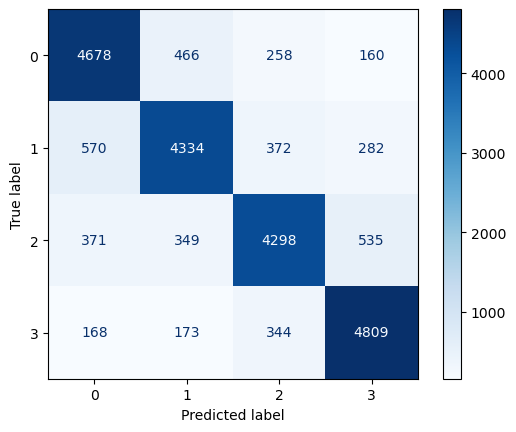

In [38]:
ConfusionMatrixDisplay.from_estimator(randomforest_classifier_pipe, X_transformed_dropped, y_categorical_transformed, cmap='Blues')
plt.show()

In [39]:
randomforest_classifier_feature_importances = pd.Series(randomforest_classifier_pipe['classifier'].feature_importances_, index=X_categorical_train.columns)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.sort_values(ascending=False)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_classifier_feature_importances

HABESTUDO_PRAT_EST_PES                   16.22
MICRODADOS_RENDA_PER_CAPITA              14.08
HABESTUDO_GES_TEMP_PLAN_EST              13.27
HABESTUDO_ST_MAT_PERC_APR                 8.84
HABESTUDO_PROB_ROT_EST                    8.20
HABESTUDO_AVAL_PROP_EXP                   5.34
MICRODADOS_TP_FAIXA_ETARIA                5.24
HABESTUDO_AJUD_TERC                       4.74
MICRODADOS_TP_COR_RACA                    4.69
HABESTUDO_TECN_TP_ACES                    4.22
MICRODADOS_TP_SEXO_F                      3.01
HABESTUDO_DIF_INFR                        2.19
MICRODADOS_TP_ESCOLA                      2.14
MICRODADOS_REGIAO_ESCOLA_Nordeste         1.88
MICRODADOS_REGIAO_ESCOLA_Sudeste          1.75
MICRODADOS_REGIAO_ESCOLA_Norte            1.48
MICRODADOS_REGIAO_ESCOLA_Centro-Oeste     1.31
MICRODADOS_REGIAO_ESCOLA_Sul              1.19
MICRODADOS_TP_ENSINO                      0.21
dtype: float64

Regressor

In [40]:
randomforest_regressor_pipe = Pipeline(steps=[
    ('scaler', scaler_processing),
    ('regressor', RandomForestRegressor(random_state=SEED)),
])

In [41]:
randomforest_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('stdscaler', StandardScaler())])),
                ('regressor', RandomForestRegressor(random_state=3))])

In [42]:
randomforest_regressor_mae_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed_dropped, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_error')
randomforest_regressor_mae_scores.mean()

57.008343420407144

In [43]:
randomforest_regressor_rmse_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed_dropped, y_numerical_transformed, cv=5, scoring='neg_root_mean_squared_error')
randomforest_regressor_rmse_scores.mean()

72.79410620780561

In [44]:
randomforest_regressor_r2_scores = cross_val_score(randomforest_regressor_pipe, X_transformed_dropped, y_numerical_transformed, cv=5, scoring='r2')
randomforest_regressor_r2_scores.mean()

0.26747697729641795

In [45]:
randomforest_regressor_mape_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed_dropped, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_percentage_error')
randomforest_regressor_mape_scores.mean()

0.1169462035006339

In [46]:
randomforest_regressor_feature_importances = pd.Series(randomforest_regressor_pipe['regressor'].feature_importances_, index=X_numerical_train.columns)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.sort_values(ascending=False)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_regressor_feature_importances

HABESTUDO_PRAT_EST_PES                   14.51
MICRODADOS_RENDA_PER_CAPITA              14.15
HABESTUDO_PROB_ROT_EST                   13.47
HABESTUDO_GES_TEMP_PLAN_EST              11.53
MICRODADOS_TP_ESCOLA                      8.19
HABESTUDO_ST_MAT_PERC_APR                 8.09
MICRODADOS_TP_FAIXA_ETARIA                4.64
HABESTUDO_AVAL_PROP_EXP                   4.18
MICRODADOS_TP_COR_RACA                    3.95
HABESTUDO_AJUD_TERC                       3.32
HABESTUDO_TECN_TP_ACES                    3.23
MICRODADOS_TP_SEXO_F                      2.16
HABESTUDO_DIF_INFR                        1.98
MICRODADOS_REGIAO_ESCOLA_Nordeste         1.67
MICRODADOS_REGIAO_ESCOLA_Sudeste          1.51
MICRODADOS_REGIAO_ESCOLA_Norte            1.17
MICRODADOS_REGIAO_ESCOLA_Centro-Oeste     1.06
MICRODADOS_REGIAO_ESCOLA_Sul              0.92
MICRODADOS_TP_ENSINO                      0.28
dtype: float64